In [1]:
# CNN(Convolutional Neural Network) - CIFAR10 Dataset
# - airplane(0),automobile(1),bird(2),cat(3),deer(4),dog(5),frog(6),horse(7),ship(8),truck(9)
# - CIFAR10 데이터에서 가각의 이미지는 32x32 크기의 작은 컬러 이미지

# 딥러닝 CNN 아키텍처
# - Feature Extractor(Conv>Pool>Conv>Pool) -> Fully-Connected(Flatten) -> Classification(Linear>Dropout->Linear)

In [2]:
# 1) import, GPU 설정
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

# 입력 이미지 크기가 고정되어 있을 때, PyTorch가 여러 가지 알고리즘 중에서 가장 빠른 Convolution 알고리즘을 자동으로 선택
# - benchmark = True로 설정하면, 처음 몇 번의 실행에서 다양한 알고리즘을 테스트한 뒤 가장 빠른 알고리즘을 캐싱해서 계속 사용한다.
# - 특히 CNN에서 Conv2D, MaxPool2D 같은 연산이 반복될 때 큰 속도 향상이 있다.
torch.backends.cudnn.benchmark = True

pytorch version :  2.7.1+cu118 , device :  cuda


In [3]:
# 2) CIFAR10 Dataset 다운로드

# 학습용 transform (데이터 증강 포함), RandomCrop과 RandomHorizontalFlip은 데이터 증강(Augmentation) 기법이기 때문에 학습용 데이터에만 적용
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5),),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))
])

# 검증 및 테스트용 transform (증강 없이 정규화만)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# train
train_dataset = datasets.CIFAR10(root='./data/CIFAR10_data',
                               train=True,
                               transform=train_transform,
                               download=True)
# test
test_dataset = datasets.CIFAR10(root='./data/CIFAR10_data',
                               train=False,
                               transform=test_transform,
                               download=True)

In [4]:
# CIFAR10 Dataset 확인
print(len(train_dataset), len(test_dataset))

50000 10000


In [5]:
# 3) CIFAR10 Dataset 데이터 분리 - train 85% : validation 15%
train_dataset_size = int(len(train_dataset) * 0.85) # train 85%
# validation_dataset_size = int(len(train_dataset) * 0.15) # validation 15%
validation_dataset_size = len(train_dataset) - train_dataset_size # validation 15%
train_dataset, validation_dataset = random_split(dataset=train_dataset, # 원본 데이터셋 여기서는 CIFAR10 학습 데이터 전체를 의미
                                                 lengths=[train_dataset_size, validation_dataset_size], # lengths 인자에 각 부분의 크기를 리스트로 전달
                                                 generator=torch.Generator().manual_seed(42)) # - 무작위 분할의 재현성을 보장, manual_seed(42)를 설정하면, 매번 실행해도 동일한 방식으로 데이터를 나눈다.

In [6]:
# CIFAR10 Dataset 데이터 분리 확인
print(len(train_dataset), len(validation_dataset), len(test_dataset))

42500 7500 10000


In [7]:
# 4) batch, dataloader 생성
BATCH_SIZE = 64

# train
train_dataset_loader = DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)

# validation
validation_dataset_loader = DataLoader(dataset=validation_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

# test
test_dataset_loader = DataLoader(dataset=test_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


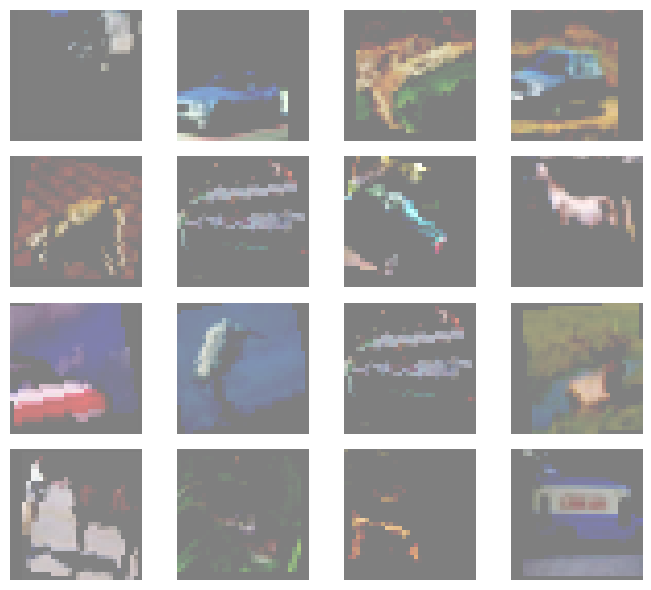

In [8]:
# 5) CIFAR10 Dataset 1개 배치 데이터 확인
images, labels = next(iter(train_dataset_loader))

# labels map 생성
# labels_map = { v:k for k, v in train_dataset.dataset.class_to_idx.items() }
labels_map = dict(enumerate(train_dataset.dataset.classes))
print(labels_map)

plt.figure(figsize=(7,6))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    img = img * 0.5 + 0.5 # matplotlib.pyplot.imshow()는 [0, 1] 또는 [0, 255] 범위의 값을 기대하므로, 시각화 전에 다시 원래대로 복원
    
    plt.subplot(cols, rows, i)
    plt.imshow(torch.permute(img, (1,2,0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# 6) CNN Model
# 딥러닝 CNN 아키텍처 - Feature Extractor(Conv>Pool>Conv>Pool) -> Fully-Connected(Flatten) -> Classification(Linear>Dropout->Linear)
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)    
        self.gap = nn.AdaptiveAvgPool2d((1, 1))    
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout25 = nn.Dropout(p=0.25)
        self.dropout50 = nn.Dropout(p=0.5)
        self.bn1 = nn.BatchNorm2d(32) # BatchNorm2d를 추가하면 일반화 성능 향상 가능
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.act = nn.LeakyReLU(0.01) # LeakyReLU는 음수 입력에 대해 아주 작은 기울기(예: 0.01)를 유지, 이렇게 하면 뉴런이 완전히 죽지 않고, 미세하게라도 학습에 참여할 수 있다.
    
    def forward(self, x):
        # 패딩이 적용되었기 때문에 컨볼루션층을 통과한 데이터는 크기는 변하지 않고 필터 개수와 동일하게 출력채널 개수만 변함, 맥스풀링층을 통과한 데이터는 1/2로 바뀌지만 채널 개수는 변하지 않음
        x = self.bn1(self.conv1(x))
        x = self.act(x)
        x = self.pooling(x) # (32, 32, 32)
        x = self.dropout25(x) # (16, 16, 32)

        x = self.bn2(self.conv2(x))
        x = self.act(x)
        x = self.pooling(x) # (16, 16, 64)
        x = self.dropout25(x) # (8, 8, 64)

        x = self.bn3(self.conv3(x))
        x = self.act(x)
        x = self.pooling(x) # (8, 8, 64)
        x = self.dropout25(x) # (4, 4, 128)

        # x = x.contiguous().view(x.size(0), -1)
        # Adaptive Pooling 추가, 기존의 x = x.contiguous().view(...) 대신 AdaptiveAvgPool2d를 통해 공간 정보를 압축하고, 그 결과를 FC 레이어에 넘기는 방식
        x = self.gap(x) # 출력: [batch, 128, 1, 1]
        x = x.view(x.size(0), -1) # [batch_size, 128]

        # Linear
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout50(x)
        
        x = self.fc2(x)

        return x

In [10]:
# 7) EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001): # min_delta를 0.0으로 설정하면 아주 미세한 개선도 인정되지 않으므로, 0.001 정도로 설정하면 더 현실적인 중단 조건이 된다.
        self.patience = patience # 개선되지 않아도 기달릴 에폭 수
        self.min_delta = min_delta # 개선으로 간주할 최소 변화량
        self.best_loss = float('inf') # 가장 낮은 validation loss
        self.counter = 0 # 개선되지 않는 에폭 수
        self.early_stop = False # 중단 여부
    
    def __call__(self, val_loss):
        # 매 에폭마다 validation loss를 받아서 개선 여부를 판단한다.
        # val_loss < self.best_loss - self.min_delta 이면 개선된 것으로 간주한다.
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        # 그렇지 않으면 counter를 증가시키고, counter가 patience 이상이면 early_stop을 True로 설정해 학습 중단 신호를 보낸다.
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [11]:
# 8) Model 객체 생성
model = CNNModel().to(DEVICE)

# loss function
loss_function = nn.CrossEntropyLoss() # Softmax() 함수 포함되어 있음

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# StepLR 스케줄러 정의
scheduler = StepLR(optimizer, step_size=3, gamma=0.5) # 5 에폭마다 학습률을 절반으로 감소하지만, 전체 에폭 수가 적다면 step_size=3 정도로 조정한다.

# Model 정보
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout50): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): LeakyReLU(negative_slope=0.01)
)


In [12]:
# 9) Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0
    train_correct = 0
    train_total = 0
    total_train_batch = len(dataloader)

    for images, labels in dataloader:
        # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        # 모델 예측값 게산
        outputs = model(x_train)

        # 손실함수값 계산
        loss = loss_function(outputs, y_train)

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item()
        train_total += y_train.size(0)
        # train_correct += (torch.argmax(outputs, 1) == y_train).sum().item()
        train_correct += (outputs.argmax(dim=1) == y_train).sum().item() # outputs 텐서 객체의 메서드 .argmax()를 호출하여 dim=1 기준으로 최대값의 인덱스를 반환


    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [13]:
# 10) Model evaluate 함수
def model_evaluate(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            # val_correct += (torch.argmax(outputs, 1) == y_val).sum().item()
            val_correct += (outputs.argmax(dim=1) == y_val).sum().item() # outputs 텐서 객체의 메서드 .argmax()를 호출하여 dim=1 기준으로 최대값의 인덱스를 반환
            
        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [14]:
# 11) Model test 함수
def model_test(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            # test_correct += (torch.argmax(outputs, 1) == y_test).sum().item()
            test_correct += (outputs.argmax(dim=1) == y_test).sum().item() # outputs 텐서 객체의 메서드 .argmax()를 호출하여 dim=1 기준으로 최대값의 인덱스를 반환
            
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        print('accuracy = ', test_avg_accuracy, ', loss = ', test_avg_loss)

In [15]:
# 12) 모델 전체 테스트셋 추론 및 오답 시각화

# 전체 테스트셋 추론 함수
def model_all_test(dataloader, model, loss_function):
    model.eval() # 추론 모드

    all_preds = []
    all_labels = []
    all_images = []

    test_loss_sum = 0
    test_correct = 0
    test_total = 0
    total_test_batch = len(dataloader)

    with torch.no_grad(): # 미분 연산 하지 않음
        for images, labels in dataloader:
            images = images.to(DEVICE) # 입력 데이터
            labels = labels.to(DEVICE) # 정답 데이터

            outputs = model(images) # 모델 예측
            _, preds = torch.max(outputs, dim=1) # 모델 예측값 추출

            all_preds.extend(preds.cpu().numpy()) # 예측값 넘파이로 변환 후 리스트 담는다.
            all_labels.extend(labels.cpu().numpy()) # 정답값 넘파이로 변환 후 리스트 담는다.
            all_images.extend(images.cpu())

            loss = loss_function(outputs, labels)
            test_loss_sum += loss.item()
            test_total += labels.size(0)
            # test_correct += (torch.argmax(outputs, 1) == labels).sum().item() # torch 모듈의 argmax() 함수를 호출하여 outputs 텐서에서 dim=1 기준으로 최대값의 인덱스를 반환
            test_correct += (outputs.argmax(dim=1) == labels).sum().item() # outputs 텐서 객체의 메서드 .argmax()를 호출하여 dim=1 기준으로 최대값의 인덱스를 반환

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total
        
        print('accuracy = ', test_avg_accuracy, 'loss = ', test_avg_loss)
      
    # labels map 생성 - train_dataset 에서 정답 label map을 생성
    # labels_map = { v : k for k, v in train_dataset.dataset.class_to_idx.items() }
    labels_map = dict(enumerate(train_dataset.dataset.classes))
    
    # Confusion Matrix 시각화 -----------------------------------------------------------------
    cm = confusion_matrix(all_labels, all_preds) # Confusion Matrix 계산
    
    # 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(labels_map.values()), 
                yticklabels=list(labels_map.values()))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

     # Classification Report ----------------------------------------------------------------
     # precision(예측한 것 중에 실제로 맞춘 비율), recall(실제 정답 중에 얼마나 맞췄는지), f1-score(precision과 recall의 조화 평균), support(각 클래스의 샘플 수)
    report = classification_report(all_labels, all_preds, target_names=list(labels_map.values()))
    print('classification report:\n', report)

    # 오답 시각화 ------------------------------------------------------------------------------
    wrong_indices = [ i for i in range(len(all_preds)) if all_preds[i] != all_labels[i] ] # 오답 샘플 추출

    print('\n오답 시각화:')
    plt.figure(figsize=(10, 9))
    cols, rows = 5, 4

    for i in range(1, cols * rows + 1):
        if i > len(wrong_indices):
            break
        idx = wrong_indices[i - 1]
        # img = all_images[i].squeeze()
        img = all_images[idx].squeeze() # 오답 시각화에서 img = all_images[i].squeeze()는 idx = wrong_indices[i - 1]로 가져온 인덱스를 써야 정확하다.
        img = all_images[idx] * 0.5 + 0.5  # 복원
        img = torch.permute(img, (1, 2, 0))  # [C,H,W] → [H,W,C]

        true_label = all_labels[idx]
        pred_label = all_preds[idx]

        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.title(f'T: {labels_map[true_label]}\nP: {labels_map[pred_label]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [16]:
# 13) Model 학습 
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 100

# EarlyStopping 객체 생성
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy),
        'Current LR = ', scheduler.get_last_lr()[0] # 학습률 확인
    )

    # EarlyStopping 체크, 매 에폭마다 val_loss를 기준으로 중단 여부를 확인한다.
    early_stopping(val_avg_loss)
    if early_stopping.early_stop:
        print(f'Early stopping triggered at epoch {epoch + 1}')
        break

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

epoch :  01 train loss =  1.874111 , train acc =  29.755294 val loss =  1.788409 , val acc =  33.026667 Current LR =  0.001
epoch :  02 train loss =  1.718641 , train acc =  36.560000 val loss =  1.771151 , val acc =  35.426667 Current LR =  0.001
epoch :  03 train loss =  1.654592 , train acc =  39.364706 val loss =  1.579079 , val acc =  42.573333 Current LR =  0.0005
epoch :  04 train loss =  1.584318 , train acc =  42.181176 val loss =  1.492692 , val acc =  46.146667 Current LR =  0.0005
epoch :  05 train loss =  1.558845 , train acc =  43.498824 val loss =  1.553367 , val acc =  44.120000 Current LR =  0.0005
epoch :  06 train loss =  1.541480 , train acc =  43.901176 val loss =  1.502607 , val acc =  45.226667 Current LR =  0.00025
epoch :  07 train loss =  1.506166 , train acc =  45.336471 val loss =  1.467347 , val acc =  47.040000 Current LR =  0.00025
epoch :  08 train loss =  1.500005 , train acc =  45.656471 val loss =  1.462337 , val acc =  47.853333 Current LR =  0.00025

In [17]:
# 14) Test Dataset 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader, model=model, loss_function=loss_function)

accuracy =  40.73 , loss =  1.8603114656582


accuracy =  40.73 loss =  1.8603114656582


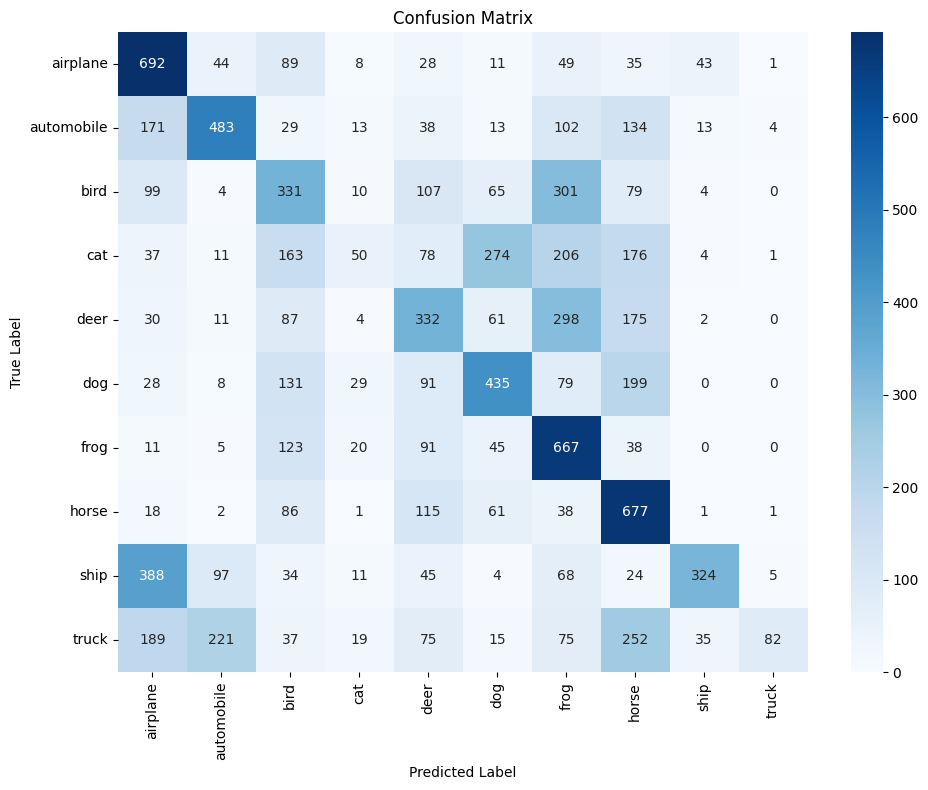

classification report:
               precision    recall  f1-score   support

    airplane       0.42      0.69      0.52      1000
  automobile       0.55      0.48      0.51      1000
        bird       0.30      0.33      0.31      1000
         cat       0.30      0.05      0.09      1000
        deer       0.33      0.33      0.33      1000
         dog       0.44      0.43      0.44      1000
        frog       0.35      0.67      0.46      1000
       horse       0.38      0.68      0.49      1000
        ship       0.76      0.32      0.45      1000
       truck       0.87      0.08      0.15      1000

    accuracy                           0.41     10000
   macro avg       0.47      0.41      0.38     10000
weighted avg       0.47      0.41      0.38     10000


오답 시각화:


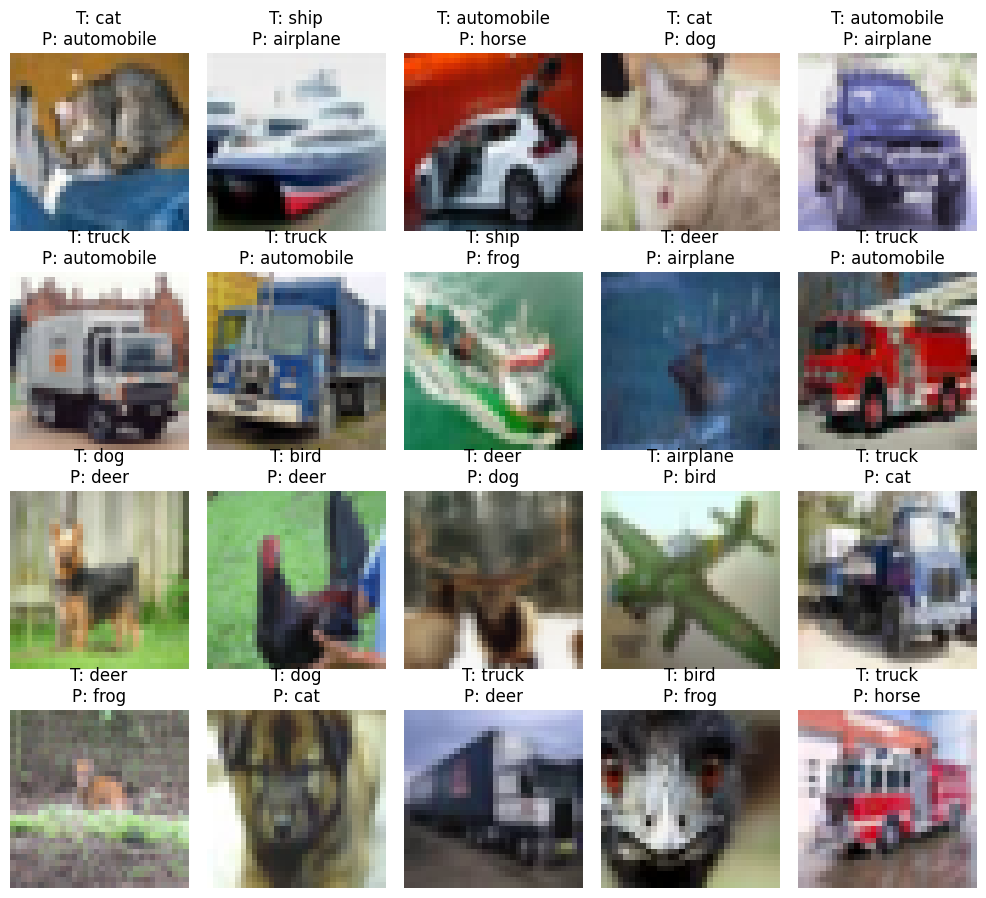

In [18]:
# 15) 모델 전체 테스트셋 추론 및 오답 시각화
model_all_test(dataloader=test_dataset_loader, model=model, loss_function=loss_function)

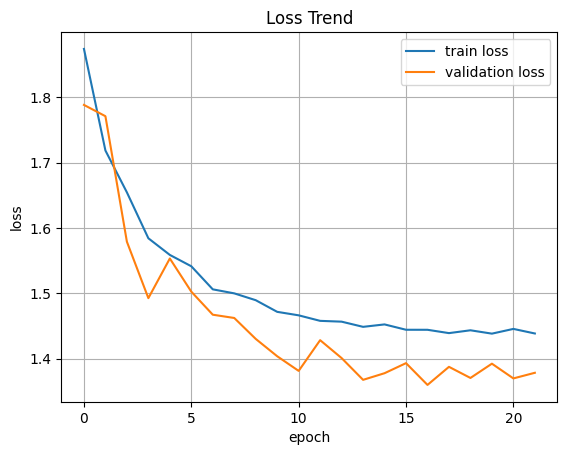

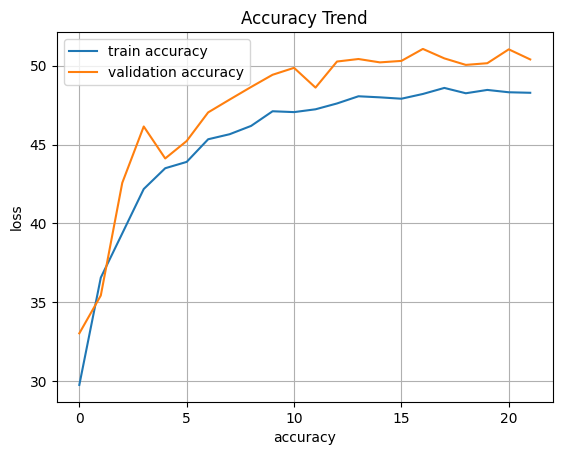

In [19]:
# 16) 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()

# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('accuracy')
plt.ylabel('loss')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()


In [20]:
# 17) Save the model checkpoint
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/model_cnn_cifar10.ckpt')

# 모델 저장 개선 형태로 저장 : 장시간 학습하거나, 실험을 반복할 때는 반드시 이 방식으로 저장
# - 모델 가중치, 옵티마이저 상태, 학습 진행 상황 (에폭, 손실 추세 등) 모두 저장
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'epoch': epoch,
#     'train_loss': train_loss_list,
#     'val_loss': val_loss_list
# }, './models/model_cnn_cifar10.ckpt')

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


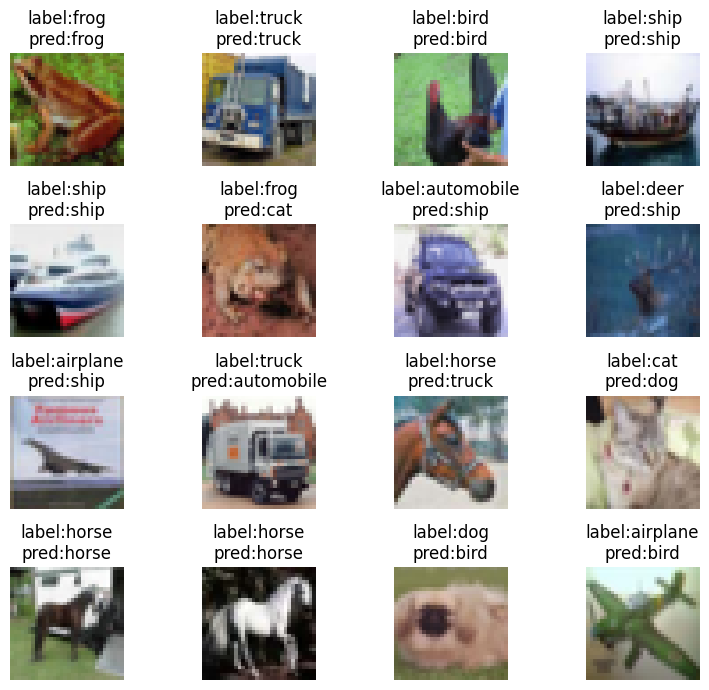

In [21]:
# 18) 단순 32개 샘플 테스트 - 모델 추론 및 예측값 추출
model = CNNModel().to(DEVICE)
model.load_state_dict(torch.load('./models/model_cnn_cifar10.ckpt'))

# 모델 로드 : 중단된 지점부터 이어서 학습
# checkpoint = torch.load('./models/model_cnn_fashion_mnist.ckpt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch'] + 1

BATCH_SIZE = 32

# test dataloader
test_image_loader = DataLoader(dataset=test_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
# test dataset 1개 배치 추출
test_images, test_labels = next(iter(test_image_loader))

# 학습/정답 데이터
x_test = test_images.to(DEVICE)
y_test = test_labels.to(DEVICE)

# 모델 추론
outputs = model(x_test)

# 모델 예측값 추출
_, preds = torch.max(outputs, 1)

# 시각화 - 추론 및 정답 비교
# labels map 생성 - train_dataset 에서 정답 label map을 생성
# labels_map = { v : k for k, v in train_dataset.dataset.class_to_idx.items() }
labels_map = dict(enumerate(train_dataset.dataset.classes))
print(labels_map)

# 시각화
sample_indices = torch.randperm(len(x_test))[:16] # 중복 없이 16개의 고유한 인덱스를 추출, 시각화할 때 같은 이미지가 반복되는 문제를 방지
plt.figure(figsize=(8, 7))

cols, rows = 4, 4

# for i in range(1, cols * rows + 1):
for i, idx in enumerate(sample_indices):
    img = test_images[idx]
    img = img * 0.5 + 0.5  # 복원
    img = torch.permute(img, (1, 2, 0))  # [C,H,W] → [H,W,C]


    label = test_labels[idx].item()
    pred = preds[idx].item()

    plt.subplot(rows, cols, i + 1)

    # torch.randint()를 통한 1개의 index 추출
    # sample_idx = torch.randint(len(x_test), size=(1,)).item()    
    # test dataloder에서 image, label, pred 값을 추출하여 시각화 비교
    # img, label, pred = test_images[sample_idx], test_labels[sample_idx].item(), preds[sample_idx].item()

    plt.title('label:' + labels_map[label] + '\npred:' + labels_map[pred])
    plt.imshow(img) # 본래 이미지 shape (3, 224, 224) -> 시각화 하기 위해서 (224, 224, 3) 변환
    plt.axis('off')
plt.tight_layout()
plt.show()